In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    f1_score,
    roc_curve,
    auc,
    brier_score_loss
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

# Proof of Concept: Simple ML Model for synthetic fire data

## The Code

### Step 1: Generate Synthetic Data

In this initial step, we create a synthetic dataset that models a geographical region to study fire occurrences. The primary objectives are to simulate diverse terrain types, incorporate environmental factors like fuel moisture, and establish a foundation for analyzing fire probability and actual fire events. 

In [4]:
# --- Step 1: Generating Synthetic Data ---
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create the 'geographical' region
domain_min, domain_max = 0, 10
num_samples = 10000

x_coords = np.random.uniform(domain_min, domain_max, num_samples)
y_coords = np.random.uniform(domain_min, domain_max, num_samples)

def assign_terrain(x, y):
    if x < 5 and y < 5:
        return 'Forest'
    elif x >= 5 and y < 5:
        return 'Grassland'
    else:
        return 'Urban'

# Assigning features to geographic areas
terrain_types = np.vectorize(assign_terrain)(x_coords, y_coords)
fuel_moisture = np.random.uniform(0, 100, num_samples)

# Compute terrain counts and ratios
terrain_counts = pd.Series(terrain_types).value_counts()
terrain_ratios = terrain_counts / num_samples

def compute_fire_probability(fuel_moisture, terrain_type, terrain_ratios):
    # Overall fire occurrence rate
    p_fire = 0.06 # based on annual frequency, not taking confidence level into account (i.e p(fire) \leq 0.06)
    P_Urban = terrain_ratios['Urban']
    P_Grassland = terrain_ratios['Grassland']
    P_Forest = terrain_ratios['Forest']
    
    # Average fuel moisture adjustment
    avg_fuel_moisture_adjustment = 0.5  # Since fuel_moisture is uniformly distributed from 0 to 100
    
    # Adjusted coefficients sum
    coefficients_sum = avg_fuel_moisture_adjustment * (P_Urban + 2 * P_Grassland + 3 * P_Forest)
    b = p_fire / coefficients_sum
    
    fm = fuel_moisture / 100
    terrain_base = {'Forest': 3 * b, 'Grassland': 2 * b, 'Urban': b}
    terrain_base_array = np.array([terrain_base[terrain] for terrain in terrain_type])
    p = terrain_base_array * (1 - fm)
    p = np.clip(p, 0, 1)
    return p

fire_prob_true = compute_fire_probability(fuel_moisture, terrain_types, terrain_ratios)
fire_occurrence = np.random.binomial(1, fire_prob_true)

data = pd.DataFrame({
    'x_coord': x_coords,
    'y_coord': y_coords,
    'terrain_type': terrain_types,
    'fuel_moisture': fuel_moisture,
    'fire_probability_true': fire_prob_true,
    'fire_occurrence': fire_occurrence
})

### Step 2: Data Preprocessing 

In this phase, we prepare the synthetic dataset for modeling by transforming and refining the data to enhance the performance and reliability of subsequent analytical or machine-learning models. The preprocessing ensures the data is in an optimal format, mitigating potential issues that could hinder model accuracy or interpretability. The key activities in this step include encoding categorical variables, scaling numerical features, assessing and addressing multicollinearity, and partitioning the dataset for training and evaluation.

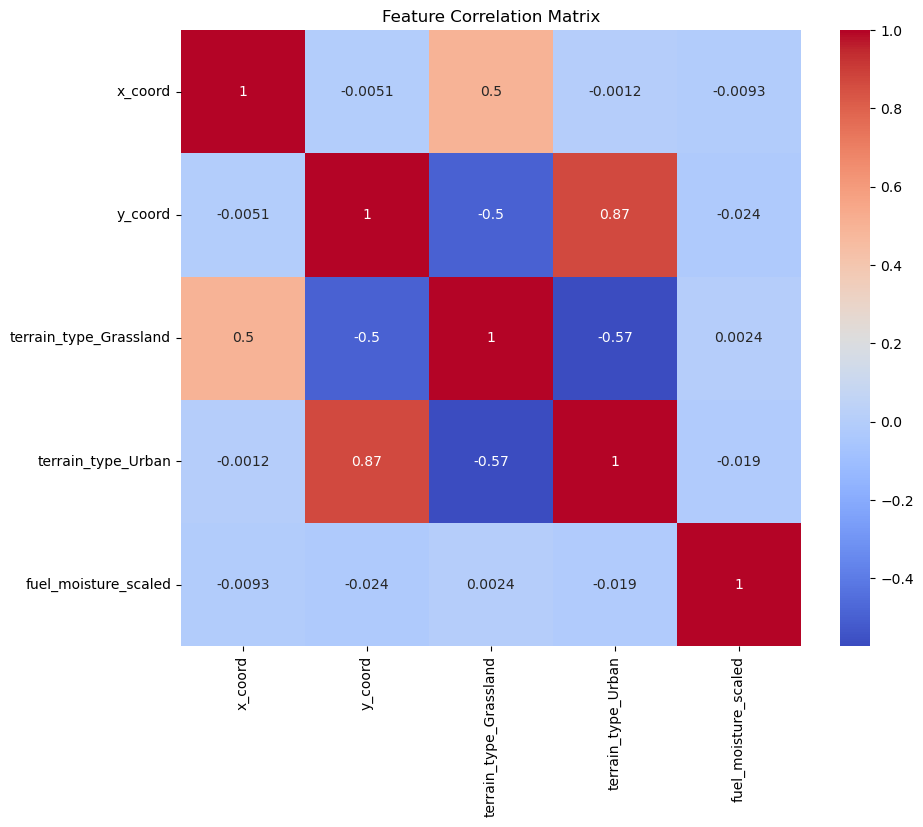

=== Variance Inflation Factor (VIF) ===
                  feature       VIF
0                 x_coord  1.577027
1                 y_coord  3.974008
2  terrain_type_Grassland  2.347068
3      terrain_type_Urban  4.730913
4    fuel_moisture_scaled  1.000726
5                constant  8.234968


In [5]:
# --- Step 2: Data Preprocessing ---
# Initialize OneHotEncoder with drop='first' to avoid multicollinearity
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') 

# Fit and transform the 'terrain_type' feature
encoder.fit(data[['terrain_type']])
terrain_ohe = encoder.transform(data[['terrain_type']])

# Retrieve the new feature names after dropping the first category (Forest = reference class)
terrain_feature_names = encoder.get_feature_names_out(['terrain_type'])

# Create a DataFrame for the encoded features
terrain_ohe_df = pd.DataFrame(terrain_ohe, columns=terrain_feature_names)

# Concatenate the encoded features with the original DataFrame
data_encoded = pd.concat([data.reset_index(drop=True), terrain_ohe_df.reset_index(drop=True)], axis=1)

# Drop the original 'terrain_type' column
data_encoded.drop('terrain_type', axis=1, inplace=True)

# Proceed with scaling as before
scaler = StandardScaler()
scaler.fit(data_encoded[['fuel_moisture']])
data_encoded['fuel_moisture_scaled'] = scaler.transform(data_encoded[['fuel_moisture']])
data_encoded.drop('fuel_moisture', axis=1, inplace=True)

# Define feature columns
feature_columns = ['x_coord', 'y_coord'] + list(terrain_feature_names) + ['fuel_moisture_scaled']
# Extract features and labels
X = data_encoded[feature_columns]  # Ensure X is a DataFrame
y = data_encoded['fire_occurrence']

# --- Multicollinearity Check ---
# Compute the correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Calculate Variance Inflation Factor (VIF)
# Add a constant term for the intercept
X_vif = X.assign(constant=1)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== Variance Inflation Factor (VIF) ===")
print(vif_data)

# Drop the 'constant' column used for VIF calculation
X_vif = X_vif.drop('constant', axis=1)

# Before splitting, extract the indices
indices = data_encoded.index.values

# Split data, including indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)

### Step 3: Building the ML model(s)

In this stage, we develop predictive models to analyze and forecast fire occurrences based on the preprocessed synthetic dataset. By leveraging both deep learning and gradient boosting techniques, we aim to capture complex patterns and interactions within the data to enhance prediction accuracy and robustness. The key activities in this step include defining a Deep Neural Network (DNN) architecture and initializing an XGBoost classifier, each offering distinct advantages for binary classification tasks like fire occurrence prediction.

In [6]:
# --- Step 3: Building Machine Learning Models ---
# Define DNN
def create_dnn_model(input_dim):
    model = Sequential([
        InputLayer(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

dnn_model = create_dnn_model(input_dim=X_train.shape[1])

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # Moved here
    random_state=42
)

### Step 4: Training the Model(s)

In this phase, we train the previously defined Deep Neural Network (DNN) and XGBoost classifier using the preprocessed training data. The objective is to optimize each model's ability to accurately predict fire occurrences by learning from the underlying patterns in the dataset. Key considerations during training include preventing overfitting, ensuring model generalization, and leveraging the strengths of each algorithm.

In [8]:
# --- Step 4: Training the Models ---
# Train DNN with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=False
)

# Train XGBoost 
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Step 5: Evaluating Model Performance

In this phase, we assess the effectiveness of the trained Deep Neural Network (DNN) and XGBoost classifier by evaluating their performance on unseen test data. The primary objective is to determine how well each model generalizes to new data and accurately predicts fire occurrences. This evaluation provides critical insights into the models' predictive capabilities and identifies areas for potential improvement. The key activities in this step include generating predictions, calculating performance metrics, and interpreting the results to compare the models' strengths and weaknesses.

In [9]:
# --- Step 5: Evaluating Model Performance ---
def opt_threshold(y_test, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
    optimal_idx = np.argmax(f1_scores) # choosing threshold off of maximum f1 score
    return thresholds[optimal_idx]
    
# XGBoost Evaluation
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_pred_proba_xgb >= opt_threshold(y_test, y_pred_proba_xgb)).astype(int)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)

print("=== XGBoost Evaluation ===")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print("Confusion Matrix:")
print(cm_xgb)
print("Classification Report:")
print(classification_rep_xgb)
print(f"Brier Score: {brier_xgb:.4f}")

# DNN Evaluation
y_pred_proba_dnn = dnn_model.predict(X_test).flatten()
y_pred_dnn = (y_pred_proba_dnn >= opt_threshold(y_test, y_pred_proba_xgb)).astype(int)

accuracy_dnn = accuracy_score(y_test, y_pred_dnn)
roc_auc_dnn = roc_auc_score(y_test, y_pred_proba_dnn)
cm_dnn = confusion_matrix(y_test, y_pred_dnn)
classification_rep_dnn = classification_report(y_test, y_pred_dnn)
brier_dnn = brier_score_loss(y_test, y_pred_proba_dnn)

print("\n=== DNN Evaluation ===")
print(f"Accuracy: {accuracy_dnn * 100:.2f}%")
print(f"ROC AUC: {roc_auc_dnn:.4f}")
print("Confusion Matrix:")
print(cm_dnn)
print("Classification Report:")
print(classification_rep_dnn)
print(f"Brier Score: {brier_dnn:.4f}")

=== XGBoost Evaluation ===
Accuracy: 83.65%
ROC AUC: 0.6739
Confusion Matrix:
[[1635  241]
 [  86   38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1876
           1       0.14      0.31      0.19       124

    accuracy                           0.84      2000
   macro avg       0.54      0.59      0.55      2000
weighted avg       0.90      0.84      0.86      2000

Brier Score: 0.0608
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== DNN Evaluation ===
Accuracy: 80.85%
ROC AUC: 0.7264
Confusion Matrix:
[[1554  322]
 [  61   63]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1876
           1       0.16      0.51      0.25       124

    accuracy                           0.81      2000
   macro avg       0.56      0.67      0.57      2000
weighted avg       0.91      0.81      0.85      2000

Brier Score: 0.0558


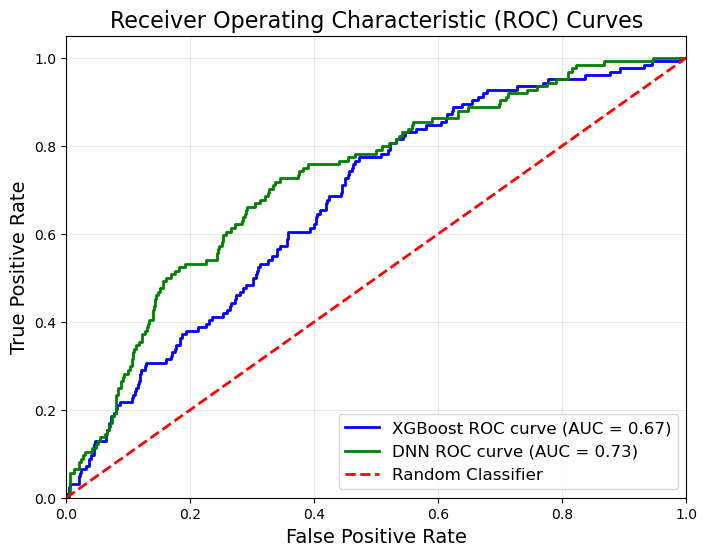

In [10]:
# --- Visualization ---
# ROC Curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_dnn, tpr_dnn, color='green', lw=2, label=f'DNN ROC curve (AUC = {roc_auc_dnn:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

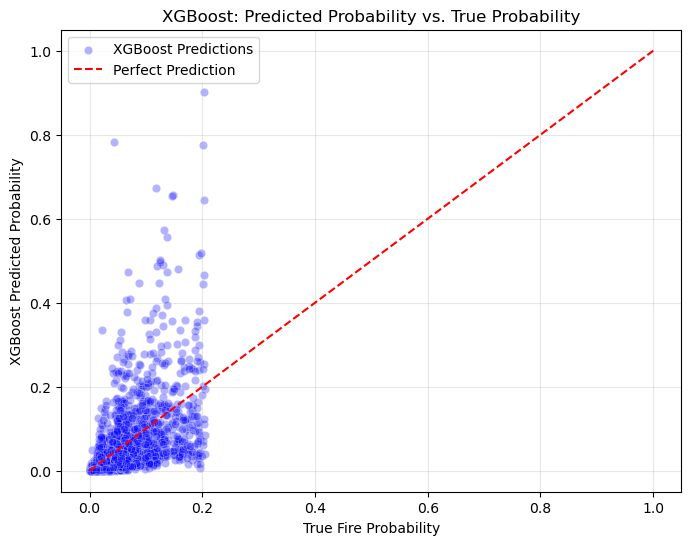

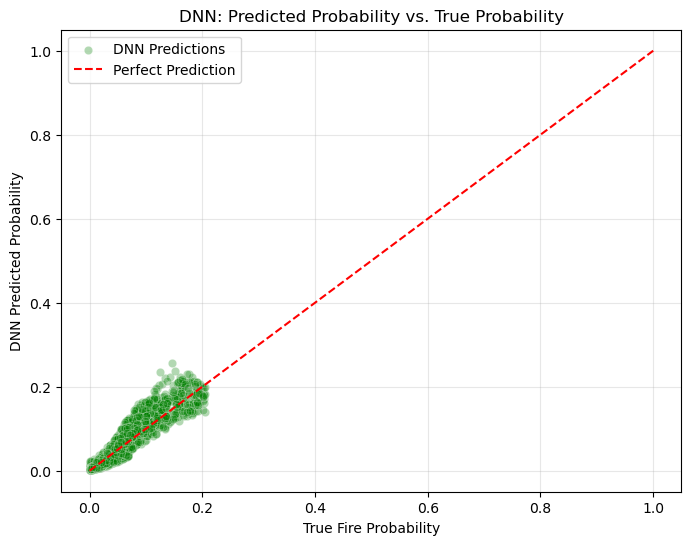

In [11]:
# Scatter Plot: Predicted vs. True Probabilities for XGBoost
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data_encoded['fire_probability_true'].iloc[idx_test],
    y=y_pred_proba_xgb,
    alpha=0.3,
    color='blue',
    label='XGBoost Predictions'
)
plt.title('XGBoost: Predicted Probability vs. True Probability')
plt.xlabel('True Fire Probability')
plt.ylabel('XGBoost Predicted Probability')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter Plot: Predicted vs. True Probabilities for DNN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data_encoded['fire_probability_true'].iloc[idx_test],
    y=y_pred_proba_dnn,
    alpha=0.3,
    color='green',
    label='DNN Predictions'
)
plt.title('DNN: Predicted Probability vs. True Probability')
plt.xlabel('True Fire Probability')
plt.ylabel('DNN Predicted Probability')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Residuals Analysis
true_probs_test = data_encoded['fire_probability_true'].iloc[idx_test]

residuals_xgb = y_pred_proba_xgb - true_probs_test
residuals_dnn = y_pred_proba_dnn - true_probs_test

plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, bins=50, kde=True, color='blue')
plt.title('XGBoost Residuals (Predicted - True Probability)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals_dnn, bins=50, kde=True, color='green')
plt.title('DNN Residuals (Predicted - True Probability)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Step 6: SHAP Feature Analysis

In this phase, we delve into the interpretability of our trained models—Deep Neural Network (DNN) and XGBoost classifier—by employing SHAP (SHapley Additive exPlanations) for feature analysis. Understanding the contribution of each feature to the model's predictions is crucial for validating model behavior, gaining actionable insights, and ensuring transparency, especially in critical applications like fire occurrence prediction.

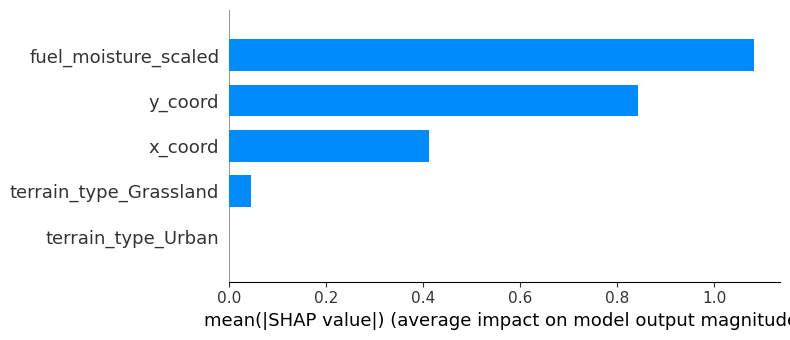

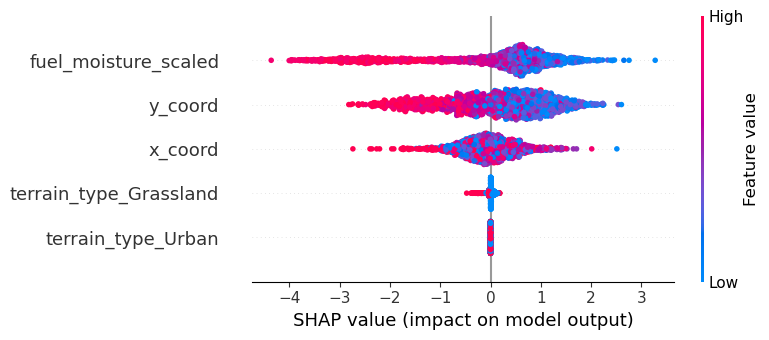

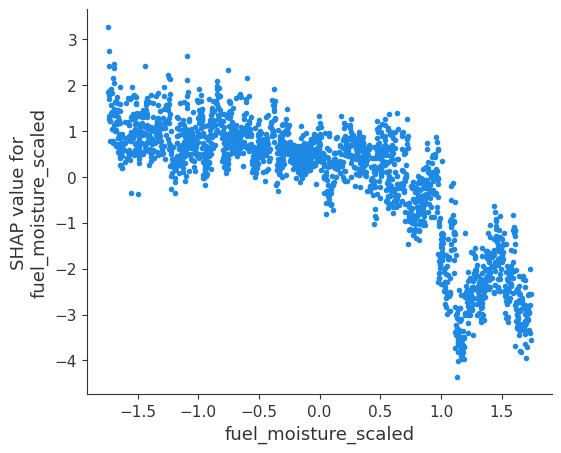

In [10]:
# --- Step 6: SHAP Feature Analysis ---
# For XGBoost
# Create the SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train, feature_names=feature_columns)

# Compute SHAP values for the test set
shap_values_xgb = explainer_xgb(X_test)

# SHAP Summary Plot for XGBoost
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test)

# Dependence Plot for 'fuel_moisture_scaled' in XGBoost
shap.dependence_plot('fuel_moisture_scaled', shap_values_xgb.values, X_test, interaction_index=None)

C:\Users\T-Spe\anaconda3\envs\ml_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


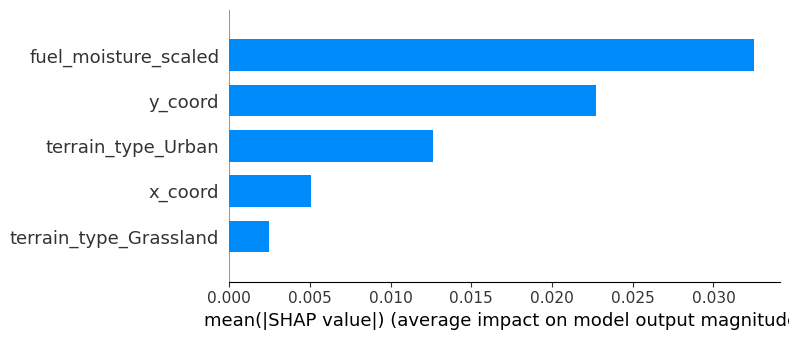

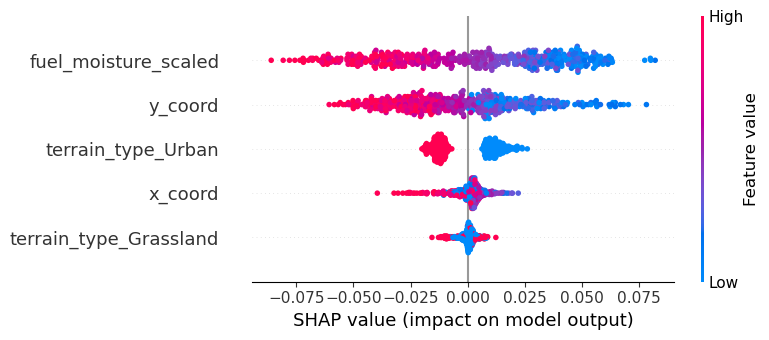

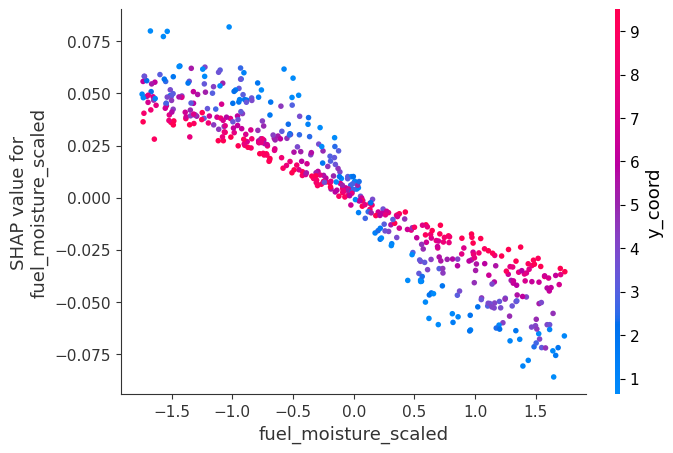

In [11]:
# For DNN
# Due to computational constraints, we'll use a subset for SHAP analysis
X_train_sample = X_train.sample(n=500, random_state=42)
X_test_sample = X_test.sample(n=500, random_state=42)

# Create the SHAP explainer for DNN
explainer_dnn = shap.GradientExplainer(dnn_model, X_train_sample.values)

# Compute SHAP values for the test sample
shap_values_dnn = explainer_dnn.shap_values(X_test_sample.values)

# Squeeze the SHAP values to remove the extra dimension
shap_values = np.squeeze(shap_values_dnn)

# Ensure the shapes match before plotting
assert shap_values.shape == X_test_sample.shape, "SHAP values and data have mismatched shapes."

# SHAP Summary Plot for DNN
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, plot_type="bar")
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns)

# Dependence Plot for 'fuel_moisture_scaled' in DNN
shap.dependence_plot('fuel_moisture_scaled', shap_values, X_test_sample, feature_names=feature_columns)

## Overview of the Code

### Step 1: Generate Synthetic Data

Here's an overview of the process:

    Reproducibility: By setting fixed random seeds for both NumPy and TensorFlow, we ensure that the data generation process can be consistently replicated, which is crucial for debugging and validating results.

    Geographical Domain Definition: We define a square region spanning from (0, 0) to (10, 10) units and generate 10,000 random spatial points within this area. This dense sampling provides a comprehensive representation of the region's variability.

    Terrain Classification: Each spatial point is categorized into one of three terrain types—Forest, Grassland, or Urban—based on its coordinates. This classification reflects realistic geographical distributions and sets the stage for differing fire behaviors across terrains.

    Environmental Factor Simulation: For every location, a fuel moisture value between 0 and 100 is randomly assigned. Fuel moisture is a critical factor influencing fire ignition and spread, as higher moisture levels typically reduce fire probability.

    Fire Probability Calculation: Combining terrain type and fuel moisture, we compute the intrinsic probability of fire occurrence for each location. Terrain types have inherent base probabilities, which are modulated by the fuel moisture to reflect the dampening effect of moisture on fire likelihood.

    Fire Occurrence Simulation: Utilizing the calculated probabilities, we simulate actual fire events, resulting in a binary outcome (1 for fire occurrence, 0 otherwise) for each spatial point. This step transforms probabilistic assessments into tangible fire occurrence data.

    Data Compilation: All generated variables—including spatial coordinates, terrain types, fuel moisture levels, calculated fire probabilities, and simulated fire occurrences—are consolidated into a structured Pandas DataFrame. This organized dataset serves as a robust foundation for subsequent analysis, modeling, or machine learning tasks related to fire prediction and management.

### Step 2: Data Preprocessing

Here's an overview of the process:

    Encoding Categorical Variables:
        One-Hot Encoding: The categorical feature terrain_type, which includes categories such as Forest, Grassland, and Urban, is transformed into a numerical format using One-Hot Encoding. This technique creates separate binary columns for each category, enabling machine learning algorithms to interpret categorical distinctions without imposing an ordinal relationship.
        Integration with Dataset: The encoded terrain features are seamlessly integrated back into the original dataset, replacing the original categorical column. This integration maintains the dataset's structure while enriching it with machine-readable representations of terrain types.

    Scaling Numerical Features:
        Standardization of Fuel Moisture: The numerical feature fuel_moisture is standardized using the StandardScaler, which centers the data by removing the mean and scales it to unit variance. This scaling ensures that the fuel moisture values contribute proportionately to the model's learning process, preventing features with larger scales from disproportionately influencing the outcomes.
        Incorporation into Dataset: The scaled fuel moisture values are added to the dataset as a new feature, and the original unscaled values are removed to maintain consistency and avoid redundancy.

    Feature Selection and Organization:
        Defining Feature Columns: A curated list of feature columns is established, encompassing spatial coordinates (x_coord, y_coord), the one-hot encoded terrain types, and the scaled fuel moisture. This selection ensures that all relevant predictors are included while maintaining a structured and organized feature set.
        Extraction of Features and Labels: The dataset is divided into feature variables (X) and the target variable (y), which is the binary fire_occurrence. This separation is essential for training supervised machine learning models where X serves as input predictors and y as the outcome to be predicted.

    Multicollinearity Assessment:
        Correlation Matrix Visualization: A correlation matrix is generated and visualized using a heatmap to identify the linear relationships between features. High correlations between predictors can indicate multicollinearity, which may distort the model's ability to accurately estimate the effect of individual features.
        Variance Inflation Factor (VIF) Calculation: VIF values are computed for each feature to quantify the degree of multicollinearity. Features with high VIF values suggest redundancy and may be candidates for removal or further investigation to enhance model stability and interpretability.
        Interpretation and Action: By evaluating the VIF results, decisions can be made to retain, transform, or exclude certain features, thereby refining the feature set to mitigate multicollinearity-related issues.

    Data Splitting for Model Training and Evaluation:
        Train-Test Split: The dataset is partitioned into training and testing subsets using an 80-20 split. This division ensures that the model is trained on a substantial portion of the data while retaining a representative sample for unbiased evaluation of its performance.
        Stratification Based on Target Variable: The split is performed with stratification on the fire_occurrence variable to maintain the original distribution of fire events in both subsets. This approach is crucial for models dealing with imbalanced classes, as it ensures that both training and testing sets accurately reflect the prevalence of fire occurrences.
        Preservation of Sample Indices: By retaining the indices of the original dataset during the split, traceability and reference integrity are maintained, facilitating downstream analyses or interpretations that may require mapping back to the original data points.

### Step 3: Building Machine Learning Model(s)

Here's an overview of the process:

    Deep Neural Network (DNN) Development:
        Model Architecture Design: A sequential DNN is constructed with an input layer matching the number of features in the training data. The network comprises two hidden layers with 16 and 8 neurons, respectively, each utilizing the ReLU (Rectified Linear Unit) activation function to introduce non-linearity and enable the network to learn complex relationships within the data.
        Output Layer Configuration: The final layer contains a single neuron with a sigmoid activation function, producing output values between 0 and 1, which correspond to the probability of fire occurrence. This setup is ideal for binary classification tasks.
        Compilation Parameters: The model is compiled using the Adam optimizer with a learning rate of 0.001, balancing efficient convergence and stability during training. The loss function is set to binary cross-entropy, which is well-suited for evaluating the discrepancy between predicted probabilities and actual binary outcomes. Additionally, accuracy is specified as a metric to monitor the proportion of correct predictions during training and evaluation.

    XGBoost Classifier Initialization:
        Model Selection: XGBoost, a powerful gradient boosting framework, is chosen for its ability to handle structured data effectively and its robustness against overfitting. It is particularly adept at capturing non-linear relationships and feature interactions, making it a strong candidate for predicting fire occurrences.
        Configuration Settings: The classifier is configured with a binary logistic objective, aligning with the binary nature of the fire occurrence prediction task. The evaluation metric is set to log loss, which measures the performance of the classification model by evaluating the probabilities output by the model. A fixed random state of 42 ensures reproducibility of results across different runs.

    Rationale for Model Selection:
        Complementary Strengths: By incorporating both a DNN and XGBoost classifier, we leverage the strengths of each model type. The DNN excels at modeling intricate patterns and interactions in high-dimensional data, while XGBoost provides powerful gradient boosting capabilities that enhance prediction accuracy and interpretability.
        Model Diversity: Utilizing multiple models allows for comparative analysis and ensemble strategies, potentially leading to improved overall performance through the combination of different modeling approaches.

    Preparation for Training and Evaluation:
        Consistency in Feature Input: Both models are designed to accept the same set of preprocessed features, ensuring a fair and consistent basis for training and evaluation.
        Scalability and Efficiency: The chosen architectures and configurations balance computational efficiency with the capacity to capture meaningful patterns, facilitating scalable model training even with large datasets.

### Step 4: Training the Model(s)

Here's an overview of the process:

    Training the Deep Neural Network (DNN) with Early Stopping:

        Early Stopping Implementation: To enhance the DNN's performance and prevent overfitting, an EarlyStopping callback is employed. This mechanism monitors the validation loss (val_loss) during training and halts the training process if no improvement is observed for a specified number of epochs (patience=10). By restoring the best weights observed during training (restore_best_weights=True), the model retains its most optimal state, ensuring robust generalization to unseen data.

        Model Fitting: The DNN is trained on the training dataset (X_train, y_train) for a maximum of 100 epochs with a batch size of 32. A portion of the training data (20%) is allocated as a validation set (validation_split=0.2) to evaluate the model's performance iteratively. The EarlyStopping callback ensures that training ceases once the model's performance plateaus, thereby conserving computational resources and maintaining model efficacy.

    Training the XGBoost Classifier:

        Model Fitting: The XGBoost classifier is trained on the same training dataset (X_train, y_train). An evaluation set comprising the testing data (X_test, y_test) is provided (eval_set=[(X_test, y_test)]) to monitor the model's performance metrics, such as log loss, during training. This setup allows for real-time assessment of the model's ability to generalize to unseen data.

        Configuration Considerations: While the XGBoost model was previously initialized with specific parameters (e.g., objective='binary:logistic', eval_metric='logloss', random_state=42), the fitting process leverages these configurations to optimize the model's predictive capabilities. The absence of verbose output (verbose=False) ensures a clean training process without excessive logging, facilitating streamlined execution.

    Rationale for Training Approaches:

        Preventing Overfitting: The incorporation of Early Stopping for the DNN is a strategic measure to prevent the model from overfitting to the training data. By monitoring validation loss and halting training upon stagnation, we ensure that the model maintains its ability to generalize rather than merely memorizing the training samples.

        Leveraging Algorithm Strengths: Training both a DNN and an XGBoost classifier allows us to capitalize on the distinct strengths of each algorithm. The DNN excels in capturing complex, non-linear relationships within the data, while XGBoost is renowned for its efficiency and effectiveness in handling structured data with feature interactions.

    Outcome of the Training Process:

        Optimized Models: Upon completion of the training process, both models are fine-tuned to their optimal states based on the training data and validation performance. The DNN benefits from its layered architecture and Early Stopping mechanism, while the XGBoost classifier harnesses gradient boosting techniques to enhance predictive accuracy.

        Preparedness for Evaluation: The trained models are now poised for the subsequent evaluation phase, where their performance will be assessed using the testing dataset. This evaluation will provide insights into each model's predictive prowess and suitability for practical fire occurrence prediction tasks.

### Step 5: Evaluating Model Performance

Here's an overview of the process:

Generating Predictions

    Probability Predictions:
        XGBoost: The predict_proba method generates the probability estimates for each class (fire occurrence) in the test set. Specifically, y_pred_proba_xgb captures the probability of fire occurring (class 1) for each sample.
        DNN: Similarly, the DNN model predicts probabilities using the predict method, resulting in y_pred_proba_dnn, which represents the likelihood of fire occurrence for each test sample.

    Class Predictions:
        Thresholding: Both models convert the probability estimates into binary class predictions (0 for no fire, 1 for fire) by applying a threshold of 0.5. This results in y_pred_xgb and y_pred_dnn, indicating the predicted classes based on the respective model's probability outputs.

Calculating Performance Metrics

For both models, a comprehensive set of evaluation metrics is calculated to provide a multifaceted view of their performance:

    Accuracy:
        Definition: Measures the proportion of correctly predicted instances out of all instances.
        Calculation: accuracy_score(y_test, y_pred) computes the accuracy by comparing the true labels with the predicted classes.
        Interpretation: High accuracy indicates that the model correctly predicts a large majority of instances.

    ROC AUC (Receiver Operating Characteristic Area Under the Curve):
        Definition: Evaluates the model's ability to distinguish between classes across all classification thresholds.
        Calculation: roc_auc_score(y_test, y_pred_proba) calculates the area under the ROC curve.
        Interpretation: A higher ROC AUC signifies better model performance in distinguishing between fire and no-fire instances.

    Confusion Matrix:
        Definition: A table that summarizes the performance of a classification model by displaying true positives, false positives, true negatives, and false negatives.
        Calculation: confusion_matrix(y_test, y_pred) generates the matrix by comparing true labels with predictions.
        Interpretation: Provides insights into specific types of prediction errors the model makes, such as misclassifying fires or non-fires.

    Classification Report:
        Definition: Provides detailed metrics including precision, recall, F1-score, and support for each class.
        Calculation: classification_report(y_test, y_pred) generates the report summarizing these metrics.
        Interpretation: Helps in understanding the model's performance in terms of both its ability to correctly identify fires (recall) and the accuracy of its positive predictions (precision).

    Brier Score:
        Definition: Measures the mean squared difference between predicted probabilities and the actual binary outcomes.
        Calculation: brier_score_loss(y_test, y_pred_proba) computes the score.
        Interpretation: Lower Brier scores indicate better calibrated probability predictions, reflecting the accuracy of the predicted probabilities.

Interpreting and Comparing Model Performance

    Performance Summary:

        XGBoost Evaluation:
            Accuracy: Indicates the overall correctness of predictions.
            ROC AUC: Reflects the model's discriminative ability.
            Confusion Matrix & Classification Report: Highlight specific strengths and weaknesses, such as precision in predicting fires or the model's tendency to miss certain fire instances.
            Brier Score: Assesses the calibration of predicted probabilities.

        DNN Evaluation:
            Accuracy, ROC AUC, Confusion Matrix, Classification Report, and Brier Score: Provide a similar set of insights tailored to the DNN's performance, allowing for a direct comparison with the XGBoost classifier.

    Comparative Analysis:
        Strengths and Weaknesses: By analyzing the metrics, we can identify which model performs better in specific aspects, such as higher accuracy or better probability calibration.
        Model Selection: Depending on the application requirements (e.g., prioritizing recall to ensure fires are not missed), one model may be preferred over the other based on the evaluation outcomes.

Outcome of the Evaluation Process

    Informed Decision-Making: The evaluation results empower stakeholders to make data-driven decisions regarding which model to deploy for fire occurrence prediction based on their performance metrics.
    Model Refinement: Insights gained from the evaluation may highlight areas where models can be further improved, such as tuning hyperparameters or addressing specific types of prediction errors.
    Benchmarking: Establishes a performance benchmark that can be used to measure future model enhancements or the impact of incorporating additional data features.

### Step 6: SHAP Feature Analysis

Here's an overview of the process:

SHAP Analysis for XGBoost Classifier

    Creating the SHAP Explainer:
        Explainer Initialization: We initialize a SHAP explainer tailored for the XGBoost model using the training data (X_train). The explainer leverages the specific characteristics of the XGBoost classifier to accurately compute SHAP values.
        Feature Names Integration: By providing feature_names=feature_columns, we ensure that SHAP plots are labeled appropriately, facilitating easier interpretation.

    Computing SHAP Values:
        Prediction Explanations: The explainer computes SHAP values for the test set (X_test), quantifying the contribution of each feature to every individual prediction.
        Resulting SHAP Values: These values are stored in shap_values_xgb, representing the impact of each feature on the model's output.

    Visualizing SHAP Values:
        Summary Plot (Bar): The bar plot (plot_type="bar") aggregates SHAP values across all samples, highlighting the most influential features in descending order of importance.
        Summary Plot (Dot): The dot plot provides a detailed view of feature impacts, showing both the magnitude and direction (positive or negative influence) of each feature across all instances.
        Dependence Plot: Focusing on 'fuel_moisture_scaled', this plot illustrates how variations in fuel moisture influence the SHAP values, potentially revealing interaction effects with other features.

SHAP Analysis for Deep Neural Network (DNN)

    Computational Considerations:
        Subset Sampling: Due to the computational intensity of SHAP analysis on neural networks, we utilize a subset of 500 samples from both training (X_train_sample) and testing (X_test_sample) datasets. This approach balances computational efficiency with the need for representative explanations.

    Creating the SHAP Explainer:
        GradientExplainer Initialization: For the DNN, we employ shap.GradientExplainer, which is suitable for gradient-based models like neural networks. The explainer is initialized with the sampled training data to capture the model's behavior effectively.

    Computing SHAP Values:
        Prediction Explanations: SHAP values for the DNN are computed for the sampled test data, resulting in shap_values_dnn.
        Shape Alignment: We ensure that the SHAP values align correctly with the test data by asserting matching shapes, preventing potential mismatches during visualization.

    Visualizing SHAP Values:
        Summary Plot (Bar): Similar to XGBoost, this plot showcases the most impactful features for the DNN, allowing for a comparative analysis of feature importance across models.
        Summary Plot (Dot): Provides granular insights into how each feature's value influences the model's predictions, highlighting both positive and negative contributions.
        Dependence Plot: Specifically examines 'fuel_moisture_scaled', revealing its relationship with the SHAP values and uncovering potential interactions with other features.

Outcome of the SHAP Feature Analysis

    Enhanced Model Understanding: SHAP analysis provides a transparent view of how each feature contributes to the models' predictions, facilitating a deeper understanding of model behavior.

    Actionable Insights:
        Fire Prevention Strategies: Insights into feature importance and interactions can inform targeted interventions, such as focusing on areas with low fuel moisture or specific terrain types.
        Model Refinement: Identifying less important features may guide feature selection or engineering efforts to streamline models and improve performance.

    Stakeholder Communication: Visualizations from SHAP analysis serve as effective tools for communicating model decisions and rationales to stakeholders, fostering trust and informed decision-making.

    Benchmarking and Validation: The analysis validates that the models are leveraging relevant features appropriately, ensuring that predictions are grounded in meaningful data relationships.